# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [61]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [62]:
# Define a function for getting dataframe
def df_from_csv(filepath, delimiter=","):
    # may add other df eda code here, info, describe, 
    return pd.read_csv(filepath, delimiter=delimiter)


# Load in the general demographics data.
pop_df = df_from_csv("./Udacity_AZDIAS_Subset.csv", ";")

# Load in the feature summary file.
feature_info_df = df_from_csv("./AZDIAS_Feature_Summary.csv",";")

#Load in customer demographics
cust_df = df_from_csv("./Udacity_CUSTOMERS_Subset.csv",";")

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [3]:
# define function for imputing of nan values
def impute_nan(original_df):
    """This function takes in 3 parameters:
    1. features is the pandas series for which identifies the feature names in the orginal df
    2. missing_or_unknown is the pandas series for which identifies the range of values for each feature which represents a missing or unknown value
    3. original_df is the pandas dataframe that contains all the original set of data to be imputed
    
    The function will first split the range of values in the missing_or unknown series into an iterable list
    Next for each of the features identified from the feature_attribute series, the data in the original dataframe will be checked against this list.
    If the value is found in the list, the original data will be replaced with NaN, else the value will be retained
    
    Returns an imputed and transformed dataframe with applicable NaN data.
    """
    for index, feature in enumerate(feature_info_df["attribute"]):
        m_u_list = feature_info_df["missing_or_unknown"].iloc[index].strip("[]").split(",")
        original_df[feature] = original_df[feature].apply(lambda x: np.nan if str(x) in m_u_list else x)
    return original_df

In [4]:
# Identify missing or unknown data values and convert them to NaNs.
pop_df_nan = impute_nan(pop_df)

In [5]:
# peek at converted df
pop_df_nan.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [6]:
# Perform an assessment of how much missing data there is in each column of the dataset
missing_data = pop_df_nan.isna().sum()/len(pop_df_nan)

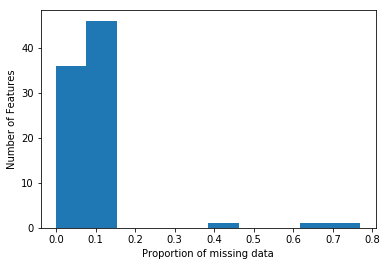

In [7]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_data)
plt.ylabel("Number of Features")
plt.xlabel("Proportion of missing data")
plt.show()

In [8]:
# save the features with high missing dat
outlier_feature = missing_data[missing_data>0.4].index
print(outlier_feature)

Index(['AGER_TYP', 'GEBURTSJAHR', 'KK_KUNDENTYP'], dtype='object')


In [9]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
pop_df_nan = pop_df_nan.drop(outlier_feature, axis=1)

In [10]:
# create function
def drop_missing_feature(original_df):
    dropped_feature = ['AGER_TYP', 'GEBURTSJAHR', 'KK_KUNDENTYP']
    dropped_df = original_df.drop(dropped_feature, axis = 1)
    return dropped_df    

#### Discussion 1.1.2: Assess Missing Data in Each Column

The following columns were removed due to high proportions of unknown or missing value post transformation: 
1. AGER_TYP - The feature is a classification of the age of the population whereby except for clearly defined elder classes, the remainder age group have no proper definition. This is probably why most of the datapoints are either unclassified or unknown as they represent customers who do not belong to the elderly group. 

2. GEBURTSJAHR - This data is once again related to age where it records the year of birth of a person. Accordingly there are linkages between missing data points here with the difficult of classification of the age type observed in the AGER_TYP feature. The missing data in year of birth is lower than the other 2 classification type features likely becuase the feature is a factual data point with little to no amiguity in class labelling or segmentation. The higher than normal missing data however, likely suggest difficult in obtaining required infomation through typical means such as in customer master data maintenace (i.e. data not filled correctly or not required in customer records creation) althought we are given we little context as to how the data in the population dataset was collected.

3. KK_KUNDENTYP - this refers to consumer patterns over the past 12 months. The missing data here suggest difficulty in tracking or reporting consumption over a period as opposed to estimates for point in time. Likely there is no clear defined scope or method of obtaining reliable consumption patterns data or that typical data collecting methods (such as customer surveys) yielded results that were inconsistent or unclear.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [11]:
# How much data is missing in each row of the dataset?
row_missing = pop_df_nan.isna().sum(axis=1)

In [12]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
def split_data(df, n):
    """
    Given a dataframe and the number of missing values in a row (n)
    return 2 dataframe in order with first set containing observations greater than n 
    and the other set containing observationsless than equal to n.
    """
    missing_row = df.isna().sum(axis=1)
    missing_high = df[missing_row > n]
    missing_low = df[missing_row <= n]
    return missing_high, missing_low

In [13]:
# what is the percentage of data that is missing
pop_df_row_miss_high, pop_df_row_miss_low = split_data(pop_df_nan, 20)
pct_data_missing = round(len(pop_df_row_miss_high)/len(pop_df_nan)*100,2)
print(f"{pct_data_missing}% of the samples have more than 20 missing features!")

10.52% of the samples have more than 20 missing features!


In [14]:
# what kind of features are missing? important features to keep, minor features can consider to keep

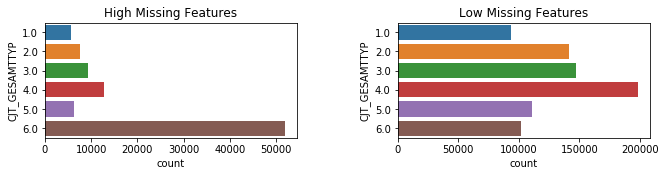

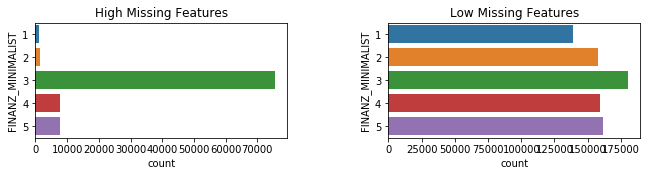

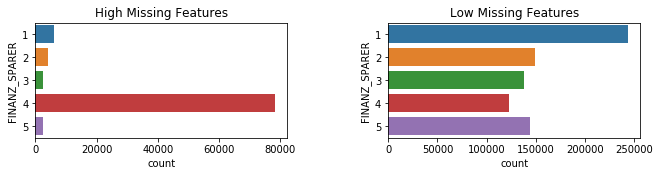

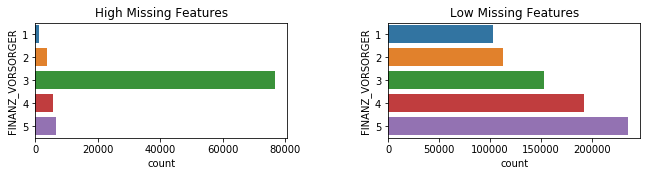

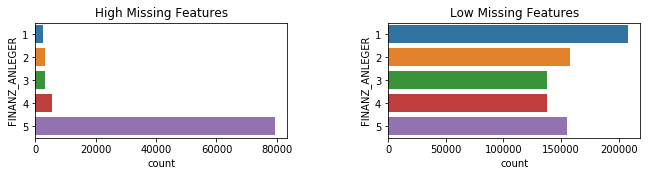

In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def plot_distribution(feature, df_high, df_low):
    fig, axs = plt.subplots(ncols = 2)
    sns.countplot(ax = axs[0], y = df_high.loc[:,feature])
    axs[0].set_title("High Missing Features")
    sns.countplot(ax = axs[1], y = df_low.loc[:,feature])
    axs[1].set_title("Low Missing Features")
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.5, 
                    wspace=0.4, 
                    hspace=0.4)
    plt.show()
    return None

for feature in pop_df_nan.columns[2:7]:
    plot_distribution(feature, pop_df_row_miss_high, pop_df_row_miss_low)

#### Discussion 1.1.3: Assess Missing Data in Each Row

From comparing the distributions across the rows with high missing features (more than 15 missing features) and those with low missing features across 5 different features, we noticed a large difference in the distributions of the values.

The features that we examined generally belongs to the finance typology for various different financial dimensions. we note that the group with high missing feature data were usually skewed and dominated by a distinct type for each of the dimensions. This is significantly different from the distributions for the low missing data group which was more spread out ammong all the typology. When we explore the typology, we noticed the missing data were usually attributed to groups that tended to save less, invest less and have lower financial interest.

As the distributions for the group with high missing features are materially different from the low missing feature group, there are potentially various other factors affecting the data quality for these specific group of persons that are not representative of the general population. As such for generalisation, we should exclude these group from evaluation and modelling.




### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [16]:
# How many features are there of each data type?
feature_info_df.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [18]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_attribute = feature_info_df.loc[feature_info_df["type"]=="categorical"]["attribute"]
multi_cat = []
binary_digit = []
binary_non_digi = []
for att in cat_attribute:
    if att in pop_df_row_miss_low.columns:
        if len(pop_df_row_miss_low[att].value_counts())>2:
            multi_cat.append(att)
        elif (len(pop_df_row_miss_low[att].value_counts())==2) and (pop_df_row_miss_low[att].value_counts().index.is_numeric()):
            binary_digit.append(att)
        elif (len(pop_df_row_miss_low[att].value_counts())==2) and not (pop_df_row_miss_low[att].value_counts().index.is_numeric()):
            binary_non_digi.append(att)
        else:
            print(f"{att} is not assigned")

In [19]:
# Re-encode categorical variable(s) to be kept in the analysis.
# drop multilevel cat
postproc_df = pop_df_row_miss_low.drop(multi_cat, axis=1)
# change binary_non_digi
postproc_df[binary_non_digi]=(postproc_df[binary_non_digi]=="W").astype(int)

In [20]:
# define function for encoding categorical features
def encode_cat_feature(original_df):
    # Create Buckets
    multi_cat = []
    binary_digi = []
    binary_nondigi = []
    
    # Get all attributes that are categorical in nature
    categorical_features = feature_info_df.loc[feature_info_df["type"]=="categorical"]["attribute"]
    
    # For each feature which still exist in the original df, determine which bucket it belongs to
    for feature in categorical_features:
        if feature in original_df.columns:
            if len(original_df[feature].value_counts())>2:
                multi_cat.append(feature)
            elif (len(original_df[feature].value_counts())==2) and (original_df[feature].value_counts().index.is_numeric()):
                binary_digi.append(feature)
            elif (len(original_df[feature].value_counts())==2) and not (original_df[feature].value_counts().index.is_numeric()):
                binary_nondigi.append(feature)
            else:
                print(f"{att} is not assigned")
    
    # Drop multi categorical features
    drop_multicat_df = original_df.drop(multi_cat, axis = 1)
    
    # Leave binary numerical features untouched
    # Encode binary non numerical features
    for binary_nondigi_feature in binary_nondigi:
        drop_multicat_df[binary_nondigi_feature]=(drop_multicat_df[binary_nondigi_feature] == drop_multicat_df[binary_nondigi_feature].values[0]).astype(int)
    
    return drop_multicat_df

#### Discussion 1.2.1: Re-Encode Categorical Features

We note that there are a total of 21 categorical type features (not including those that may have been dropped due to high missing values). Of these 21 features, 4 are in binary digit form for which no further transformation is required. 1 of the feature is a binary feature but coded in alphabet and hence we convert the binary values to integers. The remaining 14 features are multicategorical features. 2 of the features were dropped due to high missing values.

Specifically with reference to the multi categorical features, while each of the features were coded with a digit, the digits each represents a distinct category for example the "SHOPPER_TYP" feature has the digit 1 encoded for people in the population classified as "Shopping-stressed", 2 coded to people in the population classified as "family-shopper" and so on. As each category has no distinct relationship, we choose to drop these features for further analysis as the classification algorithms is distance dependent and there is no meaningful distance relationship between these encodings.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [21]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
postproc_df["Movement"] = postproc_df["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: 1 if x in [1,3,5,8,10,12,14] else 0)
postproc_df["nation"] = postproc_df["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: x//2)

In [22]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
postproc_df["CAMEO_Wealth"] = postproc_df["CAMEO_INTL_2015"].apply(lambda x: float(x)//10)
postproc_df["CAMEO_Life_Stage"] = postproc_df["CAMEO_INTL_2015"].apply(lambda x: float(x)%10)

#### Discussion 1.2.2: Engineer Mixed-Type Features

For the feature PRAEGENDE_JUGENDJAHRE, the information was split into 2 new features being a feature to record the momvement type of the data samples with 1 being movement type of "mainstream" and 0 being movement type of "avantgarde". The other component recorded was the age bracket where each decade period was encoded into 2 categories denoted by integers. To neutralise the duplication the initial integer values were halfed to represent the translated cateogry representing each distinct decade within the sample space.

For the feature CAMEO_INTL_2015, the categories were again encoded into integers where fixed integers represent a given category. To represent the household wealth, we divided the encoded integer cateogry by 10 to obtain distinct integers representing the various household wealth levels. To obtain the household constitution, we took the modulo of 10 such that the remainder constitute the integer representation for the distinct categories of household constitution.

There are a total of 7 mixed category types, besides the 2 discussed above, the remaining 5 features are:
LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, WOHNLAGE, KBA05_BAUMAX (building type), PLZ8_BAUMAX

The LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB represents life stages of the population. We choose to drop these because as identified earlier, values dealing with age and birth date are inconsistent and full of missing data and are unreliable. Life stages extends on the concepts of person's age and further delinates the age stage of a person, as such since we already dropped previously age related feature, it will make sense to drop these features as well.

The other 3 features are related to the quality of a neighbourhood by specifically, accordingly in the case of WOHNLAGE, this can actually we encoded and engineered as a ordinal scale of neighbourhood quality but for the other 2, both the type and number of buildings must be separately encoded. For our analysis however, given the ambiguity of the categorical part of the engineering process, we have decided to drop the feature from our analysis.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [23]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [24]:
mixed_attribute = feature_info_df["attribute"][feature_info_df["type"]=="mixed"]

In [25]:
clean_df = postproc_df.drop(mixed_attribute, axis=1)

In [26]:
# create function for engineering mixed features

def engineer_mixed_features(original_df):
    # specific to "PRAEGENDE_JUGENDJAHRE", create movement and nation features
    original_df["Movement"] = original_df["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: 1 if x in [1,3,5,8,10,12,14] else 0)
    original_df["nation"] = original_df["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: x//2)
    
    # specific to "CAMEO_INTL_2015", create "CAMEO_Wealth" and "CAMEO_Life_Stage" features:
    original_df["CAMEO_Wealth"] = original_df["CAMEO_INTL_2015"].apply(lambda x: float(x)//10)
    original_df["CAMEO_Life_Stage"] = original_df["CAMEO_INTL_2015"].apply(lambda x: float(x)%10)
    
    # other mixed features, to drop
    mixed_attribute = feature_info_df["attribute"][feature_info_df["type"]=="mixed"]
    dropped_mixed_df = original_df.drop(mixed_attribute, axis = 1)
    return dropped_mixed_df

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [27]:
def clean_data(original_df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    nan_df = impute_nan(original_df)
    
    # remove selected columns and rows, ...
    dropped_nan_df = drop_missing_feature(nan_df)
    row_missing = dropped_nan_df.isna().sum(axis=1)
    row_miss_high = dropped_nan_df[row_missing > 15]
    row_miss_low = dropped_nan_df[row_missing <= 15]
    
    # select, re-encode, and engineer column values.
    encoded_df = encode_cat_feature(row_miss_low)
    final_df = engineer_mixed_features(encoded_df)
    
    # Return the cleaned dataframe.
    return final_df, row_miss_high.shape[0]

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [30]:
# Impute nan to median values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
imputed_arr = imputer.fit_transform(clean_df)

In [31]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(imputed_arr))

### Discussion 2.1: Apply Feature Scaling

Imputation of missing values were conducted based on median values. This is because bulk of the integer coded values represents categorical and/or ordinal data and hence using mean values would have no real meaning. Options include using the median values or mode, however, using mode as imputation method would likely introduce skewness in the data especially for unbalanced classes for some of the data features. Using the median values would likely coerce the data points to a distribution much more centered around its median values.

For the scaling method, standard scaler was used rather than other normalization strategies such as min/max. As mentioned some of the categorical data are skewed and using min/max retains the original data distributions while using standardization would coerce the transformed data to be more centered around the mean. This is also congruent to our imputation strategy where we try to avoid adding too much skewness into the data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [32]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scaled_df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [33]:
# Investigate the variance accounted for by each principal component.
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

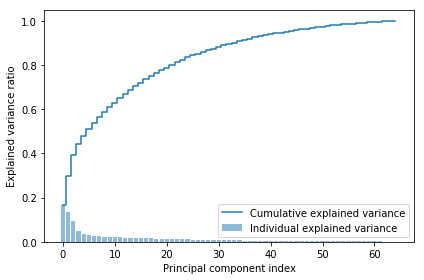

In [34]:
# Re-apply PCA to the data while selecting for number of components to retain.
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [35]:
# Choose 40 components with ~90% variance coverage
pca_30 = PCA(30)
pca_30_transform = pca_30.fit_transform(scaled_df)

##### Discussion 2.2: Perform Dimensionality Reduction

The initial data has 85 feature sets which was further reduced to 65 features. From the PCA conducted on the reduced feature dataset, it was observed that roughly 30 principal components (or less than half of the original 65 features) would help explain roughly 85% of the variations in the data. As the incremental components have diminishing marginal contributions to explained variance, 30 components was selected as it already provides sufficient coverage on the data varainces at 85% coverage.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [36]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def check_feature_weights(df, pca, component):
    """ Takes 3 arguments:
    df - this is the df where the pca is built upon and is required to map feature names
    pca - this is the fitted pca model
    component - this is the principal component of interest
    
    Maps features in the dataframe to the principal components's weights and sorts by ascending order
    Returns a dictionary of feature:component weights
    """
    feature_weights_dict = dict(zip(df.columns,pca.components_[component]))

    sorted_keys = sorted(feature_weights_dict, key = feature_weights_dict.get)

    sorted_dict = {}

    for keys in sorted_keys:
        sorted_dict[keys] = feature_weights_dict[keys]

    return sorted_dict

In [38]:
# Feature weights for the first Principal Components
check_feature_weights(clean_df, pca_30, 0)

{'MOBI_REGIO': -0.2436597127322902,
 'PLZ8_ANTG1': -0.22802232978906201,
 'KBA05_ANTG1': -0.2236658781167061,
 'KBA05_GBZ': -0.21758768595290676,
 'FINANZ_MINIMALIST': -0.21716842909621759,
 'KONSUMNAEHE': -0.16999326052546004,
 'PLZ8_GBZ': -0.16911696709547222,
 'INNENSTADT': -0.16729806239578493,
 'BALLRAUM': -0.1295917775099851,
 'CAMEO_Life_Stage': -0.12514628193102681,
 'GEBAEUDETYP_RASTER': -0.11831109789745559,
 'ALTERSKATEGORIE_GROB': -0.11452438642883545,
 'FINANZ_VORSORGER': -0.10907478733237601,
 'GREEN_AVANTGARDE': -0.10627735361842552,
 'KBA13_ANZAHL_PKW': -0.079377485099563549,
 'ANZ_PERSONEN': -0.079026526094594998,
 'SEMIO_ERL': -0.072526169460732967,
 'SEMIO_LUST': -0.068881244640287942,
 'WOHNDAUER_2008': -0.057625631714014372,
 'OST_WEST_KZ': -0.053843083760216653,
 'MIN_GEBAEUDEJAHR': -0.050734668707651906,
 'ONLINE_AFFINITAET': -0.04745728644521665,
 'SEMIO_VERT': -0.040752949408934029,
 'ALTER_HH': -0.021123032641592921,
 'RETOURTYP_BK_S': -0.015191845519467692,
 

In [39]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
check_feature_weights(clean_df, pca_30, 1)

{'nation': -0.25738357081099905,
 'SEMIO_REL': -0.25357740018907726,
 'FINANZ_SPARER': -0.23793335356243173,
 'SEMIO_TRADV': -0.23197711690680159,
 'FINANZ_UNAUFFAELLIGER': -0.2281527328489385,
 'SEMIO_PFLICHT': -0.22778828046969313,
 'SEMIO_KULT': -0.2170447039432849,
 'FINANZ_ANLEGER': -0.2052806689233341,
 'SEMIO_FAM': -0.18218902231343484,
 'SEMIO_RAT': -0.17190541231729775,
 'ONLINE_AFFINITAET': -0.16724338625468269,
 'SEMIO_MAT': -0.16277885566726552,
 'SEMIO_SOZ': -0.10120486617394241,
 'ALTER_HH': -0.09950279899129838,
 'PLZ8_ANTG1': -0.082802338628536573,
 'MOBI_REGIO': -0.082174341540647192,
 'KBA05_GBZ': -0.080736452320010435,
 'KBA05_ANTG1': -0.0696673217097286,
 'INNENSTADT': -0.068656585241613596,
 'SEMIO_VERT': -0.066828520343907655,
 'PLZ8_GBZ': -0.06558633955497345,
 'KONSUMNAEHE': -0.064843673110300079,
 'ANZ_PERSONEN': -0.061609945012938788,
 'HEALTH_TYP': -0.057941746126080683,
 'BALLRAUM': -0.055796109431592765,
 'MIN_GEBAEUDEJAHR': -0.048196130828549365,
 'GEBAEUD

In [40]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

check_feature_weights(clean_df, pca_30, 2)

{'ANREDE_KZ': -0.36985814835386344,
 'SEMIO_KAEM': -0.338974531984998,
 'SEMIO_DOM': -0.31615970495608825,
 'SEMIO_KRIT': -0.27688470218323036,
 'SEMIO_RAT': -0.2164823851879327,
 'FINANZ_ANLEGER': -0.18646347443111524,
 'SEMIO_ERL': -0.17771016215459548,
 'FINANZ_SPARER': -0.10515989266952459,
 'nation': -0.10363711723186728,
 'FINANZ_UNAUFFAELLIGER': -0.098707535420104048,
 'SEMIO_TRADV': -0.077915466726570848,
 'SEMIO_PFLICHT': -0.076710792854839199,
 'ONLINE_AFFINITAET': -0.055921376745614135,
 'FINANZ_HAUSBAUER': -0.043243272221719267,
 'PLZ8_ANTG1': -0.042543941929527228,
 'INNENSTADT': -0.038341955377626968,
 'PLZ8_GBZ': -0.036298207674754168,
 'KONSUMNAEHE': -0.034260757570348056,
 'ALTER_HH': -0.032506457619913331,
 'Movement': -0.031144848393369579,
 'BALLRAUM': -0.030630200779274534,
 'GEBAEUDETYP_RASTER': -0.028047489994165228,
 'MOBI_REGIO': -0.027689974289746996,
 'KBA05_GBZ': -0.024376735612340994,
 'KBA13_ANZAHL_PKW': -0.022581661281471769,
 'HEALTH_TYP': -0.02109343810

### Discussion 2.3: Interpret Principal Components

The three most negative features from the first 3 Principal Components include:
MOBI_REGIO, PLZ8_ANTG1, KBA05_ANTG1, nation, SEMIO_REL, FINANZ_SPARER, ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM

In the case of the first Principal Component, the number of 1-2 family houses (within a neighbourhood) and the movement patterns are the least important in explaining data variances as noted by the negative eigenvalues.

For the second principal component, nationality, religion and money saving traits least explained the variances

For the third component, gender, and the general aggresiveness (combative and dominant traits) least contributed to the explained variances of the component

The three most positive features from the first 3 Principal Components include:
SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM, SEMIO_ERL, FINANZ_VORSORGER, ALTERSKATEGORIE_GROB, CAMEO_Wealth, PLZ8_ANTG4, PLZ8_ANTG3

In the case of the first Principal Component, the higher number of family houses (within a neighbourhood) and the wealth of those households are the most important in explaining data variances as noted by the negative eigenvalues.This is in contrast to the features that least explained the variances which comprise the lower number of houses within a neighbourhood. As this is the first principal component, this shows that the status of a neighbour probably has a high influence on the overall varaiance observed in the dataset.

For the second principal component, age and financial preparedness traits most explained the variances contributed by the component. We can contrast this to the most negative features for this components which includes nationality, religion likely because it is a census data for the German population which is rather homogeneous in nationality and religion.

For the third component, dreamfulness, social and family mindedness contributed most to explained variances (i.e. opposite in personality traits to the aggressive traits that least explained variances for this component).



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [41]:
from sklearn.cluster import KMeans
# Over a number of different cluster counts...

def get_kmeans_score(data, cluster_size):
    
    #instantiate kmeans
    kmeans = KMeans(n_clusters=cluster_size)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    # Cache model
    filename = f'kmeans_model_{cluster_size}.sav'
    pickle.dump(model, open(filename, 'wb'))
    
    return score

In [42]:
# list for kmeans score by cluster size
scores = []
cluster_size = list(range(2,16))
# iterate over cluster size 2 to 15 to get kmeans scores
for center in cluster_size:
    scores.append(get_kmeans_score(pca_30_transform, center))

In [43]:
# create function to plot scree plot
def scree_plot(cluster_size, scores):   
    plt.plot(cluster_size, scores, linestyle='--', marker='o', color='b')
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.title('SSE vs. K')
    plt.show()
    return None

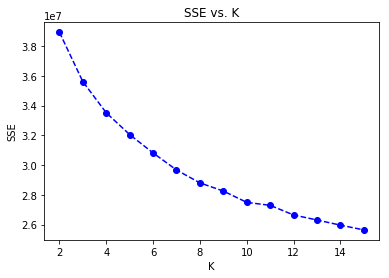

In [44]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
scree_plot(cluster_size, scores)

In [45]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
selected_model=KMeans(9)
selected_model.fit(pca_30_transform)
selected_model_filename = 'final_model.sav'
pickle.dump(selected_model, open(selected_model_filename, 'wb'))

In [46]:
# load final mode
loaded_model = pickle.load(open(selected_model_filename, 'rb'))

In [47]:
# perform label counts for the demographic data including the excluded groups as a group
label_count = pd.Series(loaded_model.labels_).value_counts()
label_count[9] = pop_df_row_miss_high.shape[0]
label_count_prop = round(label_count/label_count.sum()*100,2)

### Discussion 3.1: Apply Clustering to General Population

We observe that as the cluster sizes increases, the seperation between cluster (as indicated by the model score) decreases. From cluster size 8 onwards, the improvement in scores from increase cluster size to 10 is roughly 0.1 x 10^7. From cluster size 10 to cluster 15, the improvement in scores is only roughly about 0.15 x 10^7.

Accordingly, we can see that increasing the cluster size is giving us increasing diminishing returns in score improvement.

From looking at the scree plots the kinks appears to happen around cluster size 8 to 10 so choosing any of thes range for our cluster size selection would be feasible. For our purposes we chose the mid point of these 2 ranges for a total of 9 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [48]:
# Load in the customer demographics data.
cust_df.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1            5.0   
1        -1                     4          1            NaN   
2        -1                     4          2            2.0   
3         1                     4          1            2.0   
4        -1                     3          1            6.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   
3                  5              1                 5               2   
4                  3              1                 4               4   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      2                 2    ...            3.0         3.0   
1                      3                 2    ...            NaN         NaN   
2                      4                 4    ...            2.0         3.0   
3                      1                 2    ...            3.0         2.0   
4                      5                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         1.0         0.0          1.0       5.0       5.0     1.0   
1         NaN         NaN          NaN       NaN       NaN     NaN   
2         3.0         1.0          3.0       3.0       2.0     3.0   
3         1.0         0.0          1.0       3.0       4.0     1.0   
4         2.0         1.0          2.0       3.0       3.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          2.0       1.0  
1          NaN       NaN  
2          5.0       3.0  
3          3.0       1.0  
4          5.0       1.0  

[5 rows x 85 columns]

In [49]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

cust_df_clean, excluded_cust = clean_data(cust_df)
scaled_cust_df = pd.DataFrame(scaler.transform(imputer.transform(cust_df_clean)))
pca_30_cust = pca_30.transform(scaled_cust_df)

In [50]:
cust_label_pred = selected_model.predict(pca_30_cust)

# perform label counts for the customer data including the excluded groups as a group
cust_label_count = pd.Series(cust_label_pred).value_counts()
cust_label_count[9] = excluded_cust
cust_label_count_prop = round(cust_label_count/cust_label_count.sum()*100,2)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [51]:
joint_prop = pd.concat([label_count_prop,cust_label_count_prop], join = "inner", axis=1, sort=True)

In [52]:
joint_prop["label"]=joint_prop.index

In [53]:
joint_prop = joint_prop.melt(id_vars="label", var_name = "dataset")

In [54]:
joint_prop.dataset=joint_prop.dataset.apply(lambda x: "Demographic" if x == 0 else "Customer")

In [55]:
def plot_comparison(df):
    sns.set(style='whitegrid')
    sns.barplot(data=joint_prop, x=df.label, hue=df.dataset, y=df.value, palette="dark", alpha=.6)
    sns.despine(left=True)
    plt.ylabel("Proportion of Dataset (%)")
    plt.xlabel("Classification Labels")
    plt.title("Classification Proportions by Dataset")
    plt.legend(title = "Dataset")
    plt.show()
    return None

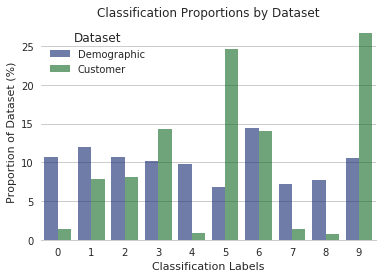

In [56]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
plot_comparison(joint_prop)

In [57]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

Cluster 5 appears to be overrepresented in the customer dataset compared to the label distribution observed from the demographics dataset.

In [72]:
# create function to descrbe features of a cluster
def describe_cluster(cluster):
    cust_cluster_5 = pca_30_cust[cust_label_pred==cluster]
    cust_cluster_5_features = scaler.inverse_transform(pca_30.inverse_transform(cust_cluster_5))
    return pd.DataFrame(cust_cluster_5_features, columns = clean_df.columns).describe()

In [73]:
# describe overrepresented cluster 5
describe_cluster(5)

ALTERSKATEGORIE_GROB     ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
count          47255.000000  47255.000000       47255.000000   47255.000000   
mean               3.505158      1.036265           5.049583       1.201055   
std                0.559328      0.126270           0.458215       0.615383   
min                0.846898      0.575237           0.873326       0.193567   
25%                3.055285      0.951616           4.873286       0.821285   
50%                3.607844      1.030174           5.140086       0.999872   
75%                3.939285      1.113263           5.346796       1.311543   
max                4.761457      2.119493           6.260473       4.844008   

       FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count      47255.000000    47255.000000           47255.000000   
mean           4.693284        1.102909               1.890238   
std            0.666078        0.692085               0.612881   
min            1.085275       -0.503192              -0.016183   
25%            4.533023        0.637415               1.507825   
50%            4.888226        1.000696               1.789319   
75%            5.109744        1.428728               2.145973   
max            6.072772        5.189099               5.633112   

       FINANZ_HAUSBAUER  GREEN_AVANTGARDE    HEALTH_TYP        ...         \
count      47255.000000      47255.000000  47255.000000        ...          
mean           2.072335          0.977455      1.858055        ...          
std            0.745569          0.097715      0.789959        ...          
min           -0.665185         -0.098900      0.623496        ...          
25%            1.652974          0.952484      1.103737        ...          
50%            2.075103          0.988428      1.881219        ...          
75%            2.449586          1.020055      2.796642        ...          
max            5.301866          1.150858      3.402119        ...          

         PLZ8_ANTG4      PLZ8_HHZ      PLZ8_GBZ        ARBEIT   ORTSGR_KLS9  \
count  47255.000000  47255.000000  47255.000000  47255.000000  47255.000000   
mean       0.438985      3.703918      3.843431      2.897184      5.340242   
std        0.435144      0.891378      0.821236      0.892866      1.617588   
min       -0.524232      0.821534      1.054949      0.749208      0.757291   
25%        0.083848      3.030500      3.206787      2.234622      4.068782   
50%        0.348281      3.673991      3.787860      2.916006      5.243067   
75%        0.806953      4.263815      4.471222      3.622626      6.587194   
max        2.552414      6.411058      6.322084      5.367940      9.268513   

           RELAT_AB      Movement        nation  CAMEO_Wealth  \
count  47255.000000  47255.000000  47255.000000  47255.000000   
mean       2.895809     -0.014371      2.952774      2.024547   
std        1.297681      0.102883      1.011994      0.808010   
min       -0.440701     -0.251843      0.987742     -0.254636   
25%        1.894237     -0.054899      2.285572      1.458738   
50%        2.960269     -0.023181      2.644974      1.913738   
75%        4.000599      0.009172      3.224918      2.483961   
max        5.918109      1.139560      7.983549      5.541151   

       CAMEO_Life_Stage  
count      47255.000000  
mean           3.733681  
std            1.120903  
min           -0.136016  
25%            3.118988  
50%            4.043903  
75%            4.451221  
max            5.865578  

[8 rows x 65 columns]

From the descriptive statistics of the customers that belong to the cluster 5, we can infer that these customers are generally 46-60 year old as indicated by the "ALTERSKATEGORIE_GROB" feature values and are males as indicated by the "ANREDE_KZ" value. The customers tend to belong to be "Prosperous Households - Older Families & Mature Couples" as indicated by both the CAMEO_Wealth and "CAMEO_Life_Stage" features with mena values of 2 and 3.7 respectively.

In [69]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

From the graph, clusters 0, 4, 7 and 8 appears to be under-represented clusters when compared to the cluster distributions of the demographics population.

In [75]:
# understanding characteristics of cluster 0,4,7,8
describe_cluster(0)

ALTERSKATEGORIE_GROB    ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
count           2741.000000  2741.000000        2741.000000    2741.000000   
mean               1.983201     1.954033           3.122943       3.216329   
std                0.602679     0.149854           1.036176       1.129874   
min                0.674939     1.220168           0.177489       0.401685   
25%                1.521428     1.884443           2.349544       2.282308   
50%                1.927047     1.972528           3.239320       3.660403   
75%                2.374557     2.053672           3.971732       4.157385   
max                3.808343     2.340357           5.441912       5.252541   

       FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count       2741.000000     2741.000000            2741.000000   
mean           2.865130        3.683647               3.342601   
std            1.113492        1.122373               1.159919   
min            0.588215        0.727645              -0.078823   
25%            2.019637        2.786347               2.477303   
50%            2.624081        3.834577               3.642884   
75%            3.560393        4.610895               4.327077   
max            6.520913        6.221328               5.625078   

       FINANZ_HAUSBAUER  GREEN_AVANTGARDE   HEALTH_TYP        ...         \
count       2741.000000       2741.000000  2741.000000        ...          
mean           2.314702          0.350629     2.223767        ...          
std            1.197079          0.452548     0.685828        ...          
min           -0.317601         -0.191247     0.624189        ...          
25%            1.389509         -0.003539     1.891315        ...          
50%            2.125803          0.061856     2.060502        ...          
75%            3.217666          0.935486     2.918492        ...          
max            5.742374          1.131019     3.385381        ...          

        PLZ8_ANTG4     PLZ8_HHZ     PLZ8_GBZ       ARBEIT  ORTSGR_KLS9  \
count  2741.000000  2741.000000  2741.000000  2741.000000  2741.000000   
mean      0.337187     3.617545     3.893328     2.627817     4.110818   
std       0.418436     0.999858     0.851359     0.945794     1.731625   
min      -0.503227     0.824427     1.325902     0.860288     0.610645   
25%       0.019321     2.941999     3.230165     1.919941     2.816560   
50%       0.214537     3.549140     3.826976     2.550984     3.822047   
75%       0.664212     4.252393     4.598119     3.384593     5.197865   
max       2.106365     6.312469     6.250690     5.459574     8.934514   

          RELAT_AB     Movement       nation  CAMEO_Wealth  CAMEO_Life_Stage  
count  2741.000000  2741.000000  2741.000000   2741.000000       2741.000000  
mean      2.458186     0.627008     5.528119      2.301003          3.303150  
std       1.329747     0.479203     1.483343      0.845359          1.212632  
min      -0.156740    -0.261014     1.133249      0.048249          0.231003  
25%       1.267413     0.031903     4.653815      1.693302          2.468056  
50%       2.443580     0.952675     5.747351      2.173116          3.588219  
75%       3.447675     1.016419     6.788344      2.867391          4.204970  
max       5.745026     1.158910     8.106594      5.207963          5.608162  

[8 rows x 65 columns]

From the above, one of the under-represented demogrpahic would belong to females aged 30-45 years old.

In [76]:
describe_cluster(7)

ALTERSKATEGORIE_GROB    ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
count           2660.000000  2660.000000        2660.000000    2660.000000   
mean               2.031066     0.970166           3.843223       3.380093   
std                0.516215     0.152054           0.897044       0.951343   
min                0.854256     0.599004           0.708453       0.843575   
25%                1.657430     0.856784           3.233062       2.459368   
50%                1.960862     0.949088           3.931899       3.702988   
75%                2.342703     1.071098           4.598085       4.151540   
max                3.943492     1.504697           5.572998       5.428089   

       FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count       2660.000000     2660.000000            2660.000000   
mean           2.699831        3.221857               3.541728   
std            0.914592        0.950819               1.043780   
min            0.574833        0.378132               0.407421   
25%            2.042385        2.467502               2.674100   
50%            2.423471        3.263665               3.776336   
75%            3.483476        3.972385               4.377865   
max            5.955633        5.541066               5.673533   

       FINANZ_HAUSBAUER  GREEN_AVANTGARDE   HEALTH_TYP        ...         \
count       2660.000000       2660.000000  2660.000000        ...          
mean           1.570553          0.410372     2.109220        ...          
std            1.005697          0.463559     0.756631        ...          
min           -0.767317         -0.149987     0.774993        ...          
25%            0.828080          0.018236     1.736708        ...          
50%            1.390519          0.090646     2.018566        ...          
75%            2.218581          0.955033     2.908299        ...          
max            5.313893          1.131276     3.424582        ...          

        PLZ8_ANTG4     PLZ8_HHZ     PLZ8_GBZ       ARBEIT  ORTSGR_KLS9  \
count  2660.000000  2660.000000  2660.000000  2660.000000  2660.000000   
mean      0.352975     3.620588     3.867050     2.599687     4.046639   
std       0.425256     0.997777     0.851501     0.944794     1.616443   
min      -0.581218     0.837571     1.573658     0.855707     0.545266   
25%       0.029019     2.949981     3.174213     1.909490     2.871585   
50%       0.230492     3.516183     3.800536     2.499076     3.861106   
75%       0.710908     4.245537     4.544950     3.282349     5.061143   
max       1.872412     6.304922     6.204834     7.080773     8.837593   

          RELAT_AB     Movement       nation  CAMEO_Wealth  CAMEO_Life_Stage  
count  2660.000000  2660.000000  2660.000000   2660.000000       2660.000000  
mean      2.440235     0.589040     5.849659      2.231885          3.276102  
std       1.316465     0.502831     1.210723      0.832407          1.172704  
min      -0.275151    -0.186988     1.712197      0.048574          0.135582  
25%       1.291297     0.000893     4.825113      1.641062          2.492346  
50%       2.402678     0.956098     6.221097      2.111650          3.434925  
75%       3.327991     1.017873     6.832814      2.722408          4.163045  
max       9.631114     1.171875     8.048640      5.131548          5.543294  

[8 rows x 65 columns]

Exploring another under represented cluster 7, it can be noted that this time the under-represented groups belong to males aged between 30-45 years old and beloning to prosperous households that have families with shcool age children

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.